<a href="https://colab.research.google.com/github/rennisson/premier_league_data/blob/main/premier_league.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos tentar analisar a tabela da atual temporada (2024/2025) da Premier League.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
league_df = pd.read_csv('https://www.football-data.co.uk/mmz4281/2425/E0.csv')

# Primeiras informações
Com o DataFrame carregado podemos iniciar algumas análises básicas sobre a liga. Vamos iniciar fazendo alguns *plots*.

<Axes: xlabel='FTR'>

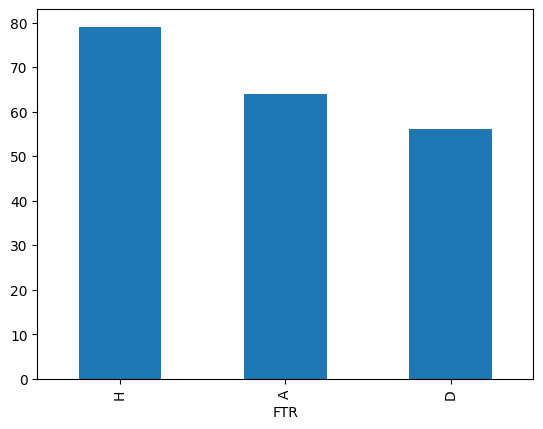

In [ ]:
league_df['FTR'].value_counts().plot(kind='bar')

Com esse gráfico é fácil ver que os times da casa aproveitam melhor a vantagem de jogarem no próprio estádio e conseguem maior número de vitórias. Mesmo assim os times visitantes têm sido duros em jogos fora de casa, conseguindo 30% das vitórias em território adversário, apenas 10% a menos que os times mandantes, como vemos nos números a seguir.

---



In [ ]:
total_games = league_df.shape[0]
print(f'Total de jogos: {total_games}')
home_wins = league_df.loc[league_df['FTR'] == 'H', 'FTR'].value_counts().sum()
away_wins = league_df.loc[league_df['FTR'] == 'A'].value_counts().sum()
draws = league_df.loc[league_df['FTR'] == 'D'].value_counts().sum()
print(f'Vitórias em casa: {home_wins / total_games * 100:.2f}%')
print(f'Vitórias fora de casa: {away_wins / total_games * 100:.2f}%')
print(f'Empates: {draws / total_games * 100:.2f}%')

Total de jogos: 199
Vitórias em casa: 39.70%
Vitórias fora de casa: 30.15%
Empates: 26.63%


Melhorando um pouco nossa análise, filtramos quais times têm melhor aproveitamento em casa. O Liverpool é o líder dessa estatística, junto com o Brentford, o que mostra a força histórica de Anfield e a pressão que o estádio causa nos adversários.

<Axes: title={'center': 'Vitórias em casa'}, xlabel='HomeTeam'>

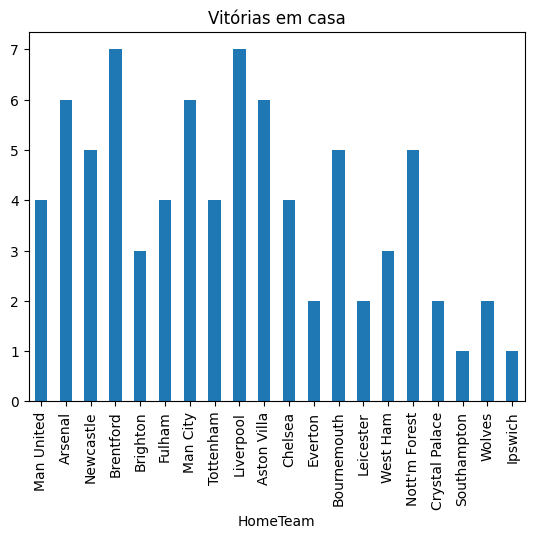

In [ ]:
number_home_wins = league_df.loc[league_df['FTR'] == 'H', 'HomeTeam'].value_counts(sort=False)
number_home_wins.plot(kind='bar', title='Vitórias em casa')

In [ ]:
number_home_wins.sort_values(ascending=False).head(5)

,count
HomeTeam,
Brentford,7
Liverpool,7
Aston Villa,6
Man City,6
Arsenal,6


Por outro lado, Ipswich, Southampton e Leicester são os times com menos vitórias como mandantes, o que explica suas situações na tabela: ambos as equipes estão na zona de rebaixamento.

In [ ]:
number_home_wins.sort_values().head(5)

,count
HomeTeam,
Ipswich,1
Southampton,1
Crystal Palace,2
Leicester,2
Everton,2


Já como visitante, o Liverpool mantém a boa forma e se destaca na liderança da estatística com 7 vitórias ao todo. Quem vem surpreendendo fora de casa é o Nottingham Forest com 7 vitórias, desempenho até melhor do que como mandante, onde tem 5 vitórias. Isso ajuda a explicar o sucesso do time até então, que desponta como terceiro lugar da Premier League.

,count
AwayTeam,
Liverpool,7
Nott'm Forest,7
Chelsea,6
Arsenal,5
Newcastle,5


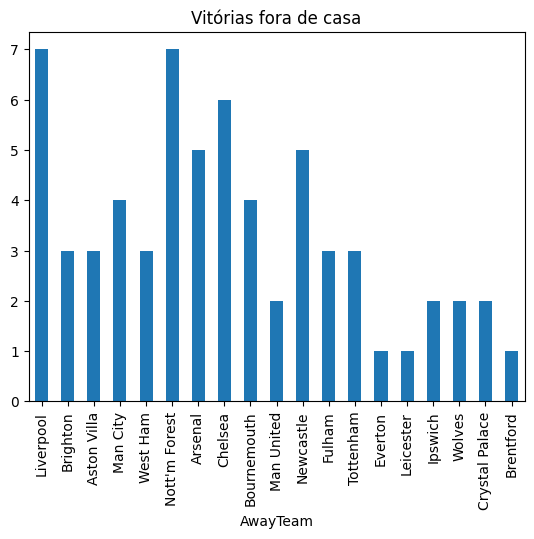

In [ ]:
number_away_wins = league_df.loc[league_df['FTR'] == 'A', 'AwayTeam'].value_counts(sort=False)
number_away_wins.plot(kind='bar', title='Vitórias fora de casa')
number_away_wins.sort_values(ascending=False).head(5)

A média de gols por partida é muito boa. Temos praticamente 3 gols por partida nessa edição de campeonato inglês, o que demonstra jogos bastante movimentados e times mais ofensivos.

In [ ]:
goals_mean = (league_df['FTHG'] + league_df['FTAG']).mean()
print(f'Média de gols por partida: {goals_mean}')

Média de gols por partida: 2.979899497487437


# Tabela de pontos
Vamos criar um dataframe vazio para ser a nossa tabela da Premier League.

In [ ]:
league_table_df = pd.DataFrame()
league_table_df['Team'] = league_df['HomeTeam'].sort_values().unique()
league_table_df['Pts'] = 0
league_table_df['MP'] = 0

Para começar vamos filtrar as vitórias em casa e fora de casa de cada time inglês, e armazenar na tabela o número de vitórias totais.

In [ ]:
# Wins
home_wins = league_df.groupby('HomeTeam').apply(lambda rows: (rows['FTR'] == 'H').sum(), include_groups=False)
away_wins = league_df.groupby('AwayTeam').apply(lambda rows: (rows['FTR'] == 'A').sum(), include_groups=False)
league_table_df['W'] = (home_wins + away_wins).values

Com o mesmo raciocínio obtemos os valores para os empates de cada time.

In [ ]:
# Draws
home_draws = league_df.groupby(['HomeTeam']).apply(lambda rows: (rows['FTR'] == 'D').sum(), include_groups=False)
away_draws = league_df.groupby(['AwayTeam']).apply(lambda rows: (rows['FTR'] == 'D').sum(), include_groups=False)
league_table_df['D'] = (home_draws + away_draws).values

E as derrotas.

In [ ]:
# Losses
home_losses = league_df.groupby(['HomeTeam']).apply(lambda rows: (rows['FTR'] == 'A').sum(), include_groups=False)
away_losses = league_df.groupby(['AwayTeam']).apply(lambda rows: (rows['FTR'] == 'H').sum(), include_groups=False)
league_table_df['L'] = (home_losses + away_losses).values

Por fim, somando todas as vitórias, empates e derrotas conseguimos o número de partidas jogadas por cada time. E também conseguimos calcular o número de pontos obtidos no campeonato até então através da fórmula

  *pontos* = 3 x *nº de vitórias* + *nº de empates*

In [ ]:
# Matches Played and Points
league_table_df['MP'] = league_table_df['W'] + league_table_df['D'] + league_table_df['L']
league_table_df['Pts'] = 3 * league_table_df['W'] + league_table_df['D']

No código abaixo estamos capturando em um único dataframe os dados de gols feitos (*full time home goals*) e gols sofridos (*full time away goals*) para times que jogaram em casa. Para tanto, separamos os dados por times usando o método *groupby()* e selecionamos apenas as colunas que desejamos extrair. Com o método *agg()* especificamos que tipo de valor cada coluna receberá; neste caso, com *sum* queremos dizer que estamos interessados na soma de todos os gols feitos/sofridos. Por fim, renomeamos cada coluna para melhor leitura e entendimento dos dados.

In [ ]:
home_team_goals = league_df.groupby('HomeTeam')[['FTHG', 'FTAG']].agg({
    "FTHG": "sum",
    "FTAG": "sum"
}).rename(
    columns={'FTHG': 'goals_for', 'FTAG': 'goals_against'}
)

Com a mesma lógica, extraímos o mesmo resultado para os times que jogaram fora de casa.

In [ ]:
away_team_goals = league_df.groupby('AwayTeam')[['FTAG', 'FTHG']].agg({
    "FTAG": "sum",
    "FTHG": "sum"
}).rename(
    columns={'FTAG': 'goals_for', 'FTHG': 'goals_against'}
)

Agora basta que somemos os gols feitos e sofridos por todas as equipes de acordo com cada jogo e obtemos os números de gols feitos e sofridos em todo o campeonato.

In [ ]:
# Goals for per team
league_table_df['GF'] = (home_team_goals['goals_for'] + away_team_goals['goals_for']).values
# Goals against per team
league_table_df['GA'] = (home_team_goals['goals_against'] + away_team_goals['goals_against']).values

Para calcular o saldo de gols, basta que façamos a diferença entre os gols feitos e sofridos por cada equipe.

In [ ]:
# Debt Goals
league_table_df['DG'] = league_table_df['GF'] - league_table_df['GA']

# Outras métricas
É interessante calcularmos algumas métricas que nos dão outras informações sobre o desempenho das equipe no campeonato. Vamos começar pela média de pontos obtidos até então.

In [ ]:
league_table_df['PPG'] = (league_table_df['Pts'] / league_table_df['MP']).round(2)

E por que não calcular a porcentagem de clean sheets de cada equipe? Isso nos dá uma noção sobre como as defesas vêm se comportando no campeonato.

In [ ]:
home_clean_sheets = league_df.groupby('HomeTeam').apply(lambda game: (game['FTAG'] <= 0).sum(), include_groups=False).rename('clean_sheets')
away_clean_sheets = league_df.groupby('AwayTeam').apply(lambda game: (game['FTHG'] <= 0).sum(), include_groups=False).rename('clean_sheets')

clean_sheets = home_clean_sheets + away_clean_sheets

Como vemos a seguir, os três times da ponta da tabela são as equipes com mais *clean sheets*. Ou seja, as defesas vêm desempenhando um papel crucial na jornada pelo título.

In [ ]:
# Apenas adicionando as estatísticas na tabela da liga
league_table_df['CS'] = (clean_sheets.values / league_table_df['MP'].values).round(2)
clean_sheets.sort_values(ascending=False).head(5)

,clean_sheets
HomeTeam,
Nott'm Forest,9
Liverpool,8
Arsenal,7
Everton,7
Newcastle,7


Ordenando a tabelas por pontos obtemos a tabela atual da Premier League.

In [ ]:
league_table_df.sort_values(by=['Pts', 'DG', 'GF'], ascending=False)

,Team,Pts,MP,W,D,L,GF,GA,DG,PPG,CS
11,Liverpool,46,19,14,4,1,47,19,28,2.42,0.42
0,Arsenal,40,20,11,7,2,39,18,21,2.00,0.35
15,Nott'm Forest,40,20,12,4,4,29,19,10,2.00,0.45
5,Chelsea,36,20,10,6,4,39,24,15,1.80,0.20
14,Newcastle,35,20,10,5,5,34,22,12,1.75,0.35
12,Man City,34,20,10,4,6,36,27,9,1.70,0.20
2,Bournemouth,33,20,9,6,5,30,23,7,1.65,0.25
1,Aston Villa,32,20,9,5,6,30,32,-2,1.60,0.10
8,Fulham,30,20,7,9,4,30,27,3,1.50,0.15
4,Brighton,28,20,6,10,4,30,29,1,1.40,0.20


from matplotlib import pyplot as plt
_df_0['Pts'].plot(kind='hist', bins=20, title='Pts')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MP'].plot(kind='hist', bins=20, title='MP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['W'].plot(kind='hist', bins=20, title='W')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['D'].plot(kind='hist', bins=20, title='D')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Pts', y='MP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MP', y='W', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='W', y='D', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='D', y='L', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Pts'].plot(kind='line', figsize=(8, 4), title='Pts')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['MP'].plot(kind='line', figsize=(8, 4), title='MP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['W'].plot(kind='line', figsize=(8, 4), title='W')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['D'].plot(kind='line', figsize=(8, 4), title='D')
plt.gca().spines[['top', 'right']].set_visible(False)

# Estatísticas